In [1]:
import numpy as np
import pandas as pd
import scanpy as sc # v1.6",
import sys
from statsmodels import robust
import matplotlib.pyplot as plt
import os.path
import anndata
import seaborn as sns
import matplotlib as mpl
import scirpy as ir
import scrublet as scr

from scipy.spatial import distance as sc_distance
from scipy.cluster import hierarchy as sc_hierarchy
from scipy import io
from scipy import sparse

In [3]:
os.chdir('/home/jovyan/data/GCA/GCA_raw_data')

path=[]
for filename in os.listdir('.'):  
    if os.path.isdir(filename):
        if filename != "cache":
            a = "./" + filename + "/filtered_feature_bc_matrix/"
            path.append(a)
            
path = [x for x in path if "ipynb_checkpoints" not in x]

                          

In [4]:
path

['./GCA100_T1/filtered_feature_bc_matrix/',
 './GCA70_B1/filtered_feature_bc_matrix/',
 './GCA92_B/filtered_feature_bc_matrix/',
 './GCA47_T2/filtered_feature_bc_matrix/',
 './GCA102_B2/filtered_feature_bc_matrix/',
 './GCA102_B1/filtered_feature_bc_matrix/',
 './GCA55_B2/filtered_feature_bc_matrix/',
 './GCA54_T2/filtered_feature_bc_matrix/',
 './GCA86_B/filtered_feature_bc_matrix/',
 './GCA55_B1/filtered_feature_bc_matrix/',
 './GCA100_B3/filtered_feature_bc_matrix/',
 './GCA92_T/filtered_feature_bc_matrix/',
 './GCA70_B2/filtered_feature_bc_matrix/',
 './GCA101_B1/filtered_feature_bc_matrix/',
 './GCA101_T1/filtered_feature_bc_matrix/',
 './GCA54_B2/filtered_feature_bc_matrix/',
 './GCA101_B3/filtered_feature_bc_matrix/',
 './GCA101_T2/filtered_feature_bc_matrix/',
 './GCA47_B2/filtered_feature_bc_matrix/',
 './GCA55_T1/filtered_feature_bc_matrix/',
 './GCA86_T/filtered_feature_bc_matrix/',
 './GCA54_B1/filtered_feature_bc_matrix/',
 './GCA70_T1/filtered_feature_bc_matrix/',
 './GCA

In [3]:
os.chdir('/home/jovyan/data/GCA/GCA_raw_data')
adata = sc.read_10x_mtx(path[0], cache=False, var_names='gene_symbols', gex_only = True)
adata.obs.index = adata.obs.index.str[:-2]
adata.obs.index = adata.obs.index + '-' + (path[0].split('/')[1])
adata.obs['sample_id'] = (path[0].split('/')[1])
adata.obs['patient_id'] = (path[0].split('/')[1]).split('_')[0]


In [ ]:
for i in range(1, len(path)):
    if i == 'GCA47_B2':
        continue
    os.chdir('/home/jovyan/data/GCA/GCA_raw_data')
    test = sc.read_10x_mtx(path[i], cache=False, var_names='gene_symbols', gex_only = True)
    test.obs.index = test.obs.index.str[:-2]
    test.obs.index = test.obs.index + '-' + (path[i].split('/')[1])
    test.obs['sample_id'] = (path[i].split('/')[1])
    test.obs['patient_id'] = (path[i].split('/')[1]).split('_')[0]
    adata = adata.concatenate(test, index_unique = None)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

In [53]:
os.chdir('/home/jovyan/data/GCA/datasets')
adata.write('GCA_raw_predoublet.h5ad', compression = 'gzip')

... storing 'sample_id' as categorical
... storing 'patient_id' as categorical
... storing 'feature_types' as categorical



***Restart***


In [42]:
os.chdir('/home/jovyan/data/GCA/datasets')
adata = sc.read_h5ad('GCA_raw_predoublet.h5ad')

In [ ]:
RUNs, DSs, CELLs, THRs, MEDs, MADs, CUTs, no_thr = [], [], [], [], [], [], [], []

# Loop through channels in anndata object:
orig_stdout = sys.stdout
sys.stdout = open('scrublet_output_file_mad.txt', 'w')

for run in adata.obs['sample_id'].unique():
    print(run)
    ad = adata[adata.obs['sample_id'] == run, :]
    x = ad.X
    scrub = scr.Scrublet(x)
    ds, prd = scrub.scrub_doublets()
    RUNs.append(run)
    DSs.append(ds)
    CELLs.append(ad.obs_names)
    # MAD calculation of threshold:
    MED = np.median(ds)
    MAD = robust.mad(ds)
    CUT = (MED + (4 * MAD))
    MEDs.append(MED)
    MADs.append(MAD)
    CUTs.append(CUT)

    try:  # not always can calculate automatic threshold
        THRs.append(scrub.threshold_)
        print('Threshold found by scrublet')
    except:
        THRs.append(0.4)
        no_thr.append(run)
        print('No threshold found, assigning 0.4 to', run)
        scrub.call_doublets(threshold=0.4) # so that it can make the plot
    fig = scrub.plot_histogram()
#    fig[0].savefig(run + '.png')

    # Alternative histogram for MAD-based cutoff
    scrub.call_doublets(threshold=CUT)
    fig = scrub.plot_histogram()
#    fig[0].savefig(run + '_mad_' + '.png')
    plt.close('all')
    print()
    print()

print()
print('The following sample(s) do not have automatic threshold:')
print(no_thr)

sys.stdout.close()
sys.stdout = orig_stdout

ns = np.array(list(map(len, DSs)))

tbl = pd.DataFrame({
    'run': np.repeat(RUNs, ns),
    'ds': np.concatenate(DSs),
    'thr': np.repeat(THRs, ns),
    'mad_MED': np.repeat(MEDs, ns),
    'mad_MAD': np.repeat(MADs, ns),
    'mad_thr': np.repeat(CUTs, ns),
    }, index=np.concatenate(CELLs))

tbl['auto_prd'] = tbl['ds'] > tbl['thr']
tbl['mad_prd'] = tbl['ds'] > tbl['mad_thr']

tbl.to_csv('doublets_score_GCA_with_mad.csv', header=True, index=True)

In [19]:
adata.obs = adata.obs.merge(tbl, how = 'left', left_index = True, right_index = True)

In [20]:
os.chdir('/home/jovyan/data/GCA/datasets')
adata.write('GCA_raw_postdoublet.h5ad', compression = 'gzip')

... storing 'sample_id' as categorical
... storing 'patient_id' as categorical
... storing 'run' as categorical
... storing 'auto_prd' as categorical
... storing 'mad_prd' as categorical




***Restart post Scrublet***



In [19]:
os.chdir('/home/jovyan/data/GCA/datasets')
adata = sc.read_h5ad('GCA_raw_postdoublet.h5ad')

In [44]:
#add metadata

os.chdir('/home/jovyan/data/GCA/stats')
meta = pd.read_csv('GCA_metadata.csv')


test = adata.obs.merge(meta, left_on = 'sample_id', right_on = 'sample_id', how = 'left')
test.index = adata.obs.index

adata.obs = test
del adata.obs['patient_id_y']
adata.obs.rename(columns={"patient_id_x": "patient_id"}, inplace = True)

In [45]:
#add clinical metadata
os.chdir('/home/jovyan/data/GCA/datasets')
meta = pd.read_csv('PoV_patients_for_meta.csv')

test = adata.obs.merge(meta, how = 'left', left_on = 'patient_id', right_on = 'patient_id')
test.index = adata.obs.index

adata.obs = test

In [ ]:
blood = adata[adata.obs.tissue == "blood",:]
tissue = adata[adata.obs.tissue == "tissue",:]

In [14]:
adata = adata[adata.obs.auto_prd != 'True',:]

/home/jovyan/my-conda-envs/GCA_py/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [29]:
adata = tissue.concatenate(blood, index_unique = None)

In [15]:
sc.pp.filter_cells(adata, min_genes=200)
#sc.pp.filter_genes(adata, min_cells=3)

Trying to set attribute `.obs` of view, copying.


In [6]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs.pct_counts_mt < 20, :]

In [7]:
os.chdir('/home/jovyan/data/GCA/datasets')
adata.write('GCA_filtered.h5ad', compression = 'gzip')


***Build raw annotated data***


In [10]:
os.chdir('/home/jovyan/data/GCA/datasets')
adata = sc.read_h5ad('GCA_filtered.h5ad')

In [12]:
#import annotation from google colab
os.chdir('/home/jovyan/data/GCA/stats')
anno = pd.read_csv('anno_1019.csv', index_col = 0)

In [13]:
adata.obs = adata.obs.merge(anno, how = 'left', left_index = True, right_index = True)

In [15]:
adata = adata[adata.obs.anno.isin(['B_cell_imm_blood', 'B_cell_mat_blood', 'CD14_blood', 'CD4_1_tissue',
       'CD4_2_tissue', 'CD4_EM_blood', 'CD4_cytotoxic_blood',
       'CD4_exhausted_tissue', 'CD4_naive_CM_blood', 'CD4_overlap_blood',
       'CD8_Eff_blood', 'CD8_naive_blood', 'CD8_tissue', 'DC_blood',
       'DC_tissue', 'Endothelium_1_tissue', 'Endothelium_2_tissue',
       'Epi_blood', 'Epithelium_tissue', 'HSC_blood', 'Lymph_endo_tissue',
       'Mac1_tissue', 'Mac2_tissue', 'Melanocyte_tissue', 'Muscle_tissue',
       'MyoFB_tissue', 'NK_56hi_blood', 'NK_56lo_blood', 'NK_tissue',
       'Plasma_blood', 'Plasma_tissue', 'Platelets_blood', 'RBC_blood',
       'Transitional_tissue', 'Treg_blood', 'VSMC_tissue']),:]

In [7]:
os.chdir('/home/jovyan/data/GCA/stats')
adata.obs[['anno', 'patient_id', 'diagnosis', 'tissue']].to_csv('initial_clustering_stats.csv')

In [20]:
os.chdir('/home/jovyan/data/GCA/datasets')
adata.write('gca_annotated_raw.h5ad', compression = 'gzip')

/home/jovyan/my-conda-envs/GCA_py/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'anno' as categorical


In [40]:
adata.obs.tissue.value_counts()

blood     131039
tissue     18983
Name: tissue, dtype: int64



***Export for R***



In [29]:
os.chdir('/home/jovyan/data/GCA/datasets')
adata = sc.read_h5ad('gca_annotated_raw.h5ad')

In [35]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [27]:
os.chdir('/home/jovyan/data/GCA/R_conversion')
adata.obs.to_csv('cells.csv')
adata.var.to_csv('genes.csv')

io.mmwrite('GCA_raw.mtx', sparse.csr_matrix(adata.X))

adata.obs.to_csv('meta.csv')



***QC plots***



In [14]:
os.chdir('/home/jovyan/data/GCA/datasets')
adata = sc.read_h5ad('GCA_raw_predoublet.h5ad')

In [26]:
os.chdir('/home/jovyan/data/GCA/datasets')
adata = sc.read_h5ad('GCA_raw_postdoublet.h5ad')

In [50]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

Trying to set attribute `.var` of view, copying.


In [48]:
adata = adata[~(adata.obs.sample_id == 'GCA47_B2'),:]

In [53]:
adata.obs.columns

Index(['sample_id', 'patient_id', 'batch', 'Unnamed: 0', 'tissue', 'diagnosis',
       'Diagnosis', 'cDNA', 'Age', 'Sex', 'Days_on_steroids', 'CRP', 'PMR',
       'Ischaemic', 'US', 'Intimal_hyperplasia', 'Giant cells',
       'n_genes_by_counts', 'total_counts', 'total_counts_mt',
       'pct_counts_mt'],
      dtype='object')

In [59]:
adata.obs.groupby['patient_id', 'tissue'].size()

TypeError: 'method' object is not subscriptable

In [50]:
os.chdir('/home/jovyan/data/GCA/stats')
adata.obs[['sample_id', 'diagnosis']].value_counts().to_csv('cell_counts_by_sample.csv')

... storing 'sample_id' as categorical
... storing 'patient_id' as categorical
... storing 'tissue' as categorical
... storing 'diagnosis' as categorical
... storing 'Diagnosis' as categorical
... storing 'cDNA' as categorical
... storing 'Sex' as categorical
... storing 'PMR' as categorical
... storing 'Ischaemic' as categorical
... storing 'US' as categorical
... storing 'Intimal_hyperplasia' as categorical
... storing 'Giant cells' as categorical


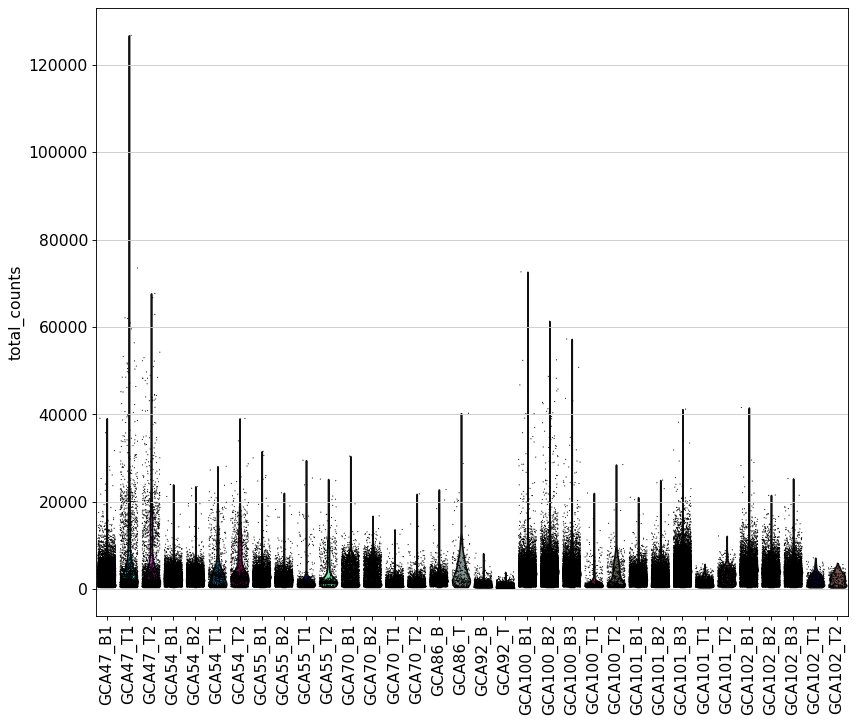

In [56]:
sc.set_figure_params(dpi=80, dpi_save = 300, figsize = [10,10])

os.chdir('/home/jovyan/data/GCA/figures')

sc.pl.violin(adata, ['total_counts'], groupby = 'sample_id', jitter=0.4, 
             multi_panel=True,
             rotation = 90, save = 'QC_total_counts.png')

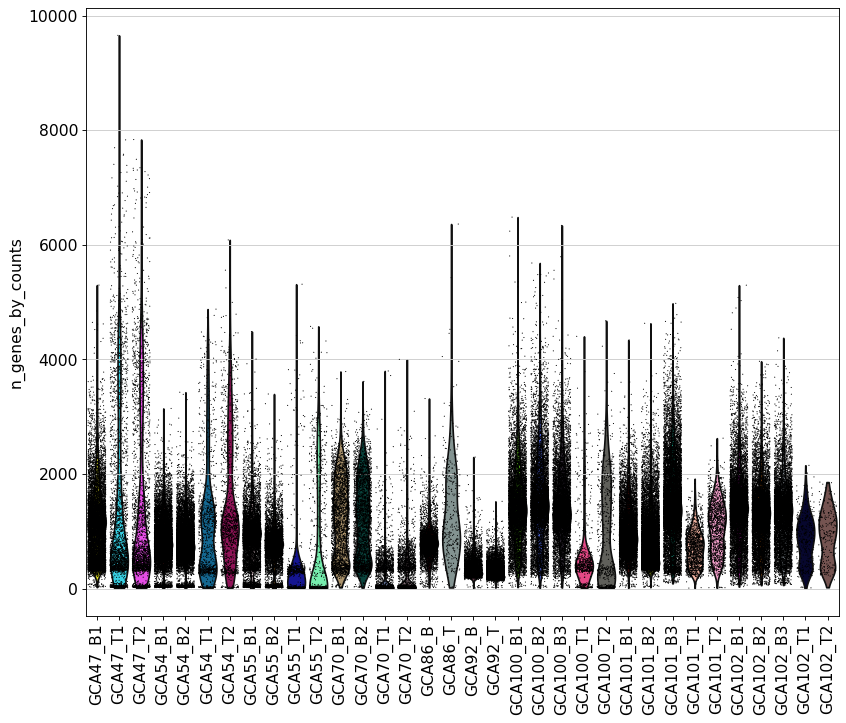

In [42]:
sc.set_figure_params(dpi=80, dpi_save = 300, figsize = [10,10])

os.chdir('/home/jovyan/data/GCA/figures')

sc.pl.violin(adata, ['n_genes_by_counts'], groupby = 'sample_id', jitter=0.4, 
             multi_panel=True,
             rotation = 90, save = 'QC_genes_by_counts.png')

In [59]:
os.chdir('/home/jovyan/data/GCA/stats')
adata.obs.groupby(['sample_id']).mean('n_genes_by_counts')[['n_genes_by_counts', 'total_counts', 'pct_counts_mt']].to_csv('QC_stats.csv')

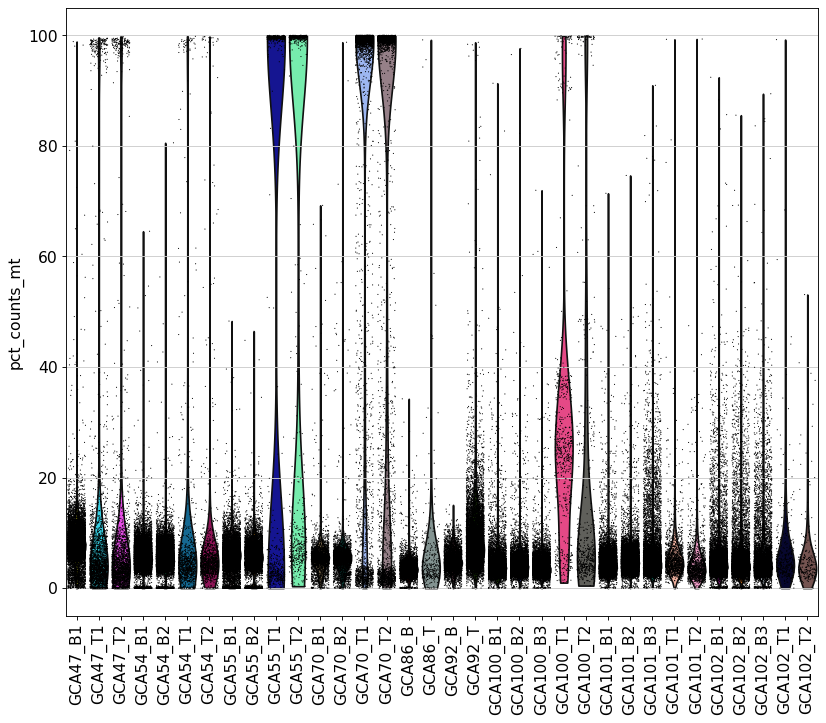

In [43]:
sc.set_figure_params(dpi=80, dpi_save = 300, figsize = [10,10])

os.chdir('/home/jovyan/data/GCA/figures')

sc.pl.violin(adata, ['pct_counts_mt'], groupby = 'sample_id', jitter=0.4, multi_panel=True, 
             rotation = 90, save = 'QC_mito_content.png')